In [2]:
!pip install faiss-cpu

In [5]:
import os
import pandas as pd
import faiss
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

# **Prepare Dataset**

## Download

In [24]:
# !gdown ...

In [25]:
# sudo apt-get install unzip
# !unzip Dataset.zip

## Processing

In [3]:
dataset_path = 'Dataset'

In [6]:
os.listdir(dataset_path)

['Avatar_Amy_Pascal.jpg',
 'Avatar_Amy_Redford.jpg',
 'Avatar_Andrew_Bernard.jpg',
 'Avatar_Carla_Gay_Balingit.jpg',
 'Avatar_Andrew_Cuomo.jpg',
 'Avatar_Anil_Ramsook.jpg',
 'Avatar_Aaron_Eckhart.jpg',
 'Avatar_Camille_Lewis.jpg',
 'Avatar_Aaron_Guiel.jpg']

In [7]:
image_paths = []
labels = []

In [8]:
for filename in os.listdir(dataset_path):
    if filename.endswith(('.jpg', '.JPG', '.png', '.jpeg')):
        image_paths.append(os.path.join(dataset_path, filename))
        file_name = filename.split('.')[0]
        label = file_name[7:]
        labels.append(label)

In [9]:
image_paths

['Dataset/Avatar_Amy_Pascal.jpg',
 'Dataset/Avatar_Amy_Redford.jpg',
 'Dataset/Avatar_Andrew_Bernard.jpg',
 'Dataset/Avatar_Carla_Gay_Balingit.jpg',
 'Dataset/Avatar_Andrew_Cuomo.jpg',
 'Dataset/Avatar_Anil_Ramsook.jpg',
 'Dataset/Avatar_Aaron_Eckhart.jpg',
 'Dataset/Avatar_Camille_Lewis.jpg',
 'Dataset/Avatar_Aaron_Guiel.jpg']

In [10]:
labels

['Amy_Pascal',
 'Amy_Redford',
 'Andrew_Bernard',
 'Carla_Gay_Balingit',
 'Andrew_Cuomo',
 'Anil_Ramsook',
 'Aaron_Eckhart',
 'Camille_Lewis',
 'Aaron_Guiel']

In [11]:
df = pd.DataFrame({'image_path': image_paths, 'label': labels})
df

image_path               label
0          Dataset/Avatar_Amy_Pascal.jpg          Amy_Pascal
1         Dataset/Avatar_Amy_Redford.jpg         Amy_Redford
2      Dataset/Avatar_Andrew_Bernard.jpg      Andrew_Bernard
3  Dataset/Avatar_Carla_Gay_Balingit.jpg  Carla_Gay_Balingit
4        Dataset/Avatar_Andrew_Cuomo.jpg        Andrew_Cuomo
5        Dataset/Avatar_Anil_Ramsook.jpg        Anil_Ramsook
6       Dataset/Avatar_Aaron_Eckhart.jpg       Aaron_Eckhart
7       Dataset/Avatar_Camille_Lewis.jpg       Camille_Lewis
8         Dataset/Avatar_Aaron_Guiel.jpg         Aaron_Guiel

# Store Image like vector

## Vectorize Image

In [12]:
IMAGE_SIZE = 300
VECTOR_DIM = 300 * 300 * 3  # For RGB images (300x300x3)

In [15]:
index = faiss.IndexFlatL2(VECTOR_DIM)
label_map = []

In [16]:
def image_to_vector(image_path):
    """Convert image to normalized vector"""
    # img = Image.open(image_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    img = Image.open(image_path)
    if img.mode == 'RGBA':
        print("Image is RGBA, converting to RGB...")
        # Convert the image to RGB
        img = img.convert('RGB')
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img)
    print("img_array shape", img_array.shape)

    # Handle grayscale images (convert to RGB)
    if len(img_array.shape) == 2:
        img_array = np.stack((img_array,)*3, axis=-1)

    # Normalize pixel values to [0, 1]
    vector = img_array.astype('float32') / 255.0
    return vector.flatten()

In [17]:
for idx, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']

    try:
        vector = image_to_vector(image_path)
        # Add to Faiss index
        index.add(np.array([vector]))
        label_map.append(label)
    except Exception as e:
        print("image_path: ",image_path)
        print(f"Error processing {image_path}: {e}")

img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)
img_array shape (300, 300, 3)


In [18]:
# Save the index and label map for later use
faiss.write_index(index, "employee_images.index")
np.save("label_map.npy", np.array(label_map))

## Search

In [19]:
def search_similar_images(query_image_path, k=5):
    """Search for similar employee images"""
    # Load index and labels
    index = faiss.read_index("employee_images.index")
    label_map = np.load("label_map.npy")

    # Convert query image to vector
    query_vector = image_to_vector(query_image_path)

    # Search in Faiss
    distances, indices = index.search(np.array([query_vector]), k)

    # Get results
    results = []
    for i in range(len(indices[0])):
        employee_name = label_map[indices[0][i]]
        distance = distances[0][i]
        results.append((employee_name, distance))

    return results

In [20]:
def display_query_and_top_matches(query_image_path):
    query_img = Image.open(query_image_path)
    query_img = query_img.resize((300, 300))

    plt.figure(figsize=(5, 5))
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')
    plt.show()

    matches = search_similar_images(query_image_path)

    """Display the top 5 matching employee images with distances"""
    # Get the image paths for the results
    top_matches = []
    for name, distance in matches:
        # Find the image path for this employee in df
        img_path = df[df['label'] == name]['image_path'].values[0]
        top_matches.append((name, distance, img_path))
    top_matches

    # Create plot
    plt.figure(figsize=(15, 5))
    for i, (name, distance, img_path) in enumerate(top_matches):
        img = Image.open(img_path)
        img = img.resize((300, 300))

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{name}\nDist: {distance:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Example 1

In [21]:
# Test Image
# query_image_path1 = "/content/Dataset/Avatar_Amy_Pascal.jpg"
query_image_path1 = "Dataset/Avatar_Amy_Pascal.jpg"

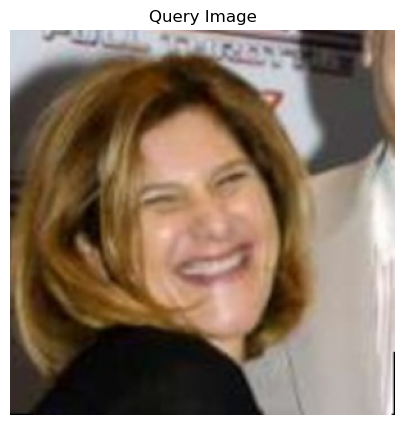

img_array shape (300, 300, 3)


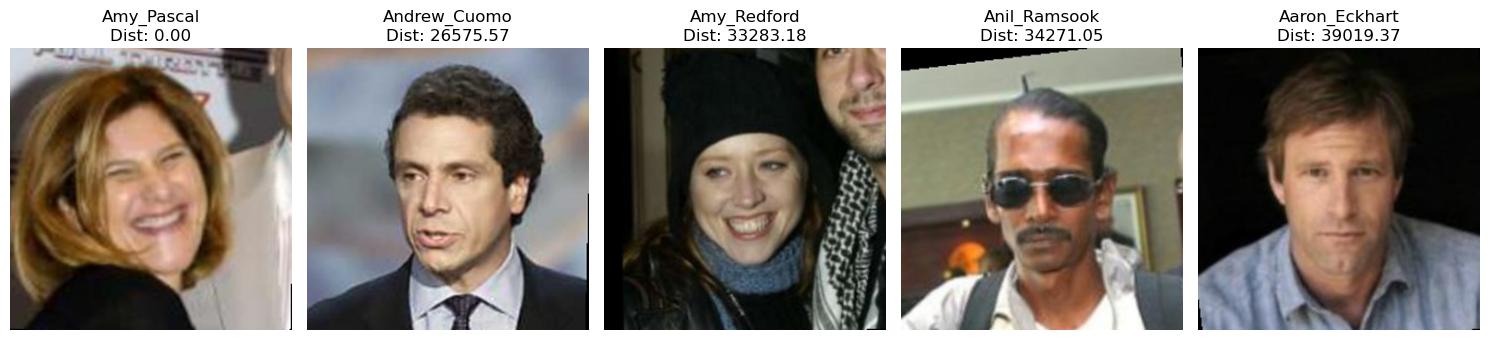

In [22]:
display_query_and_top_matches(query_image_path1)

### Example 2 (New query image)

In [23]:
# Stored Image
# query_image_path2 = "/content/test1.jpg"
query_image_path2 = "test1.jpg"

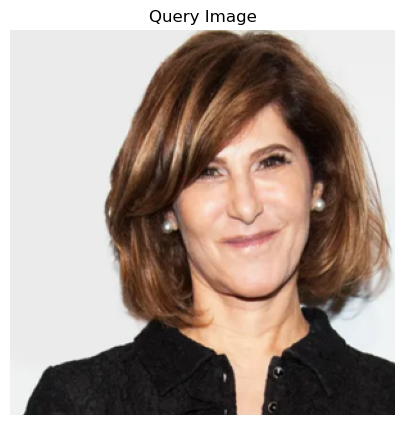

Image is RGBA, converting to RGB...
img_array shape (300, 300, 3)


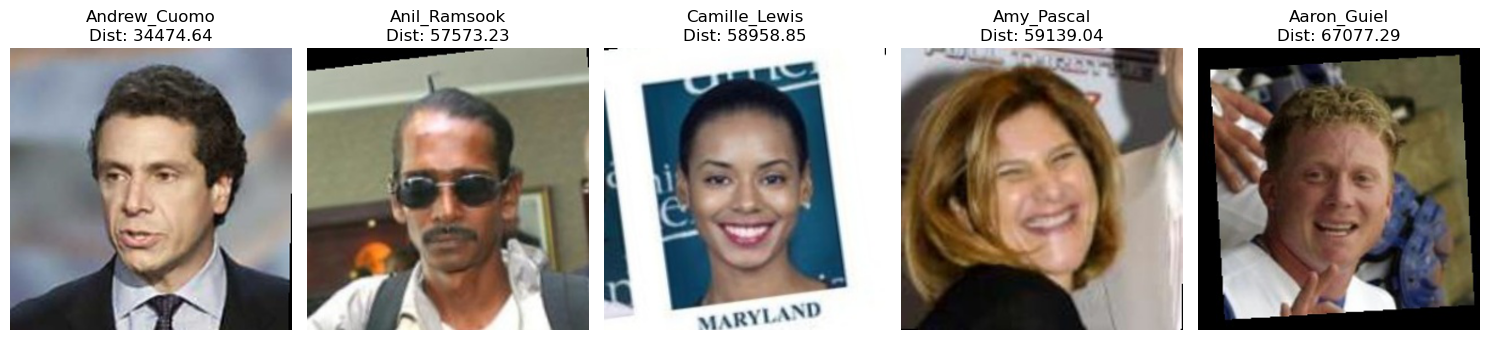

In [24]:
display_query_and_top_matches(query_image_path2)

### Example 3 (New query image)

In [29]:
# Stored Image
query_image_path3 = "test2.png"

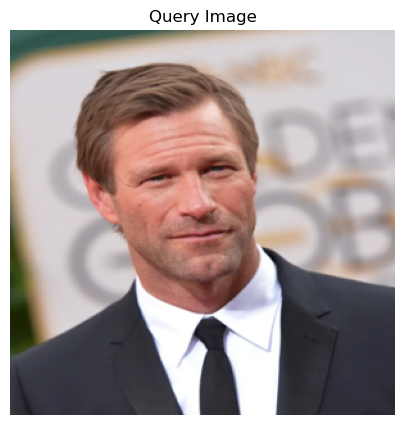

Image is RGBA, converting to RGB...
img_array shape (300, 300, 3)


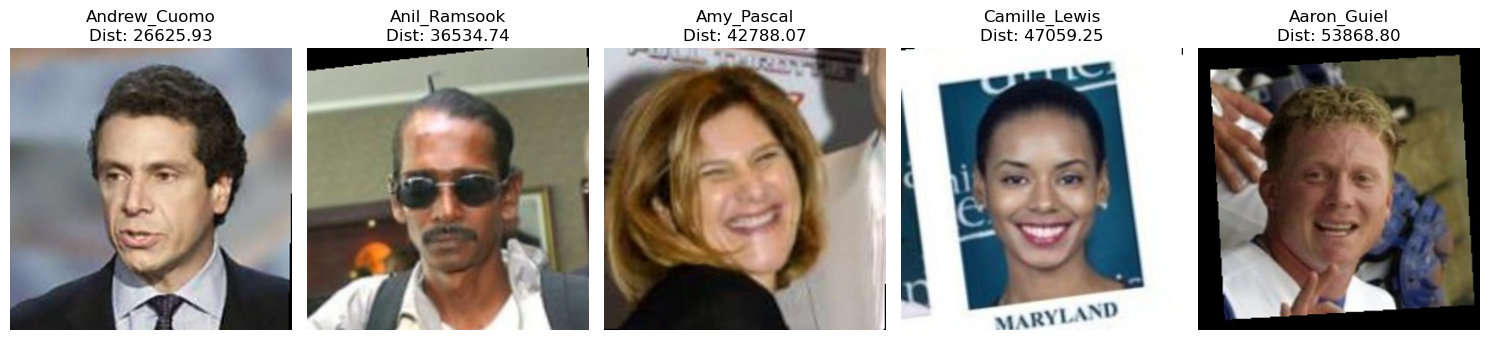

In [31]:
display_query_and_top_matches(query_image_path3)

# Store feature of Image

## Vectorize Image

In [34]:
# Initialize ResNet50 model for feature extraction
model = models.resnet50(pretrained=True)
# Remove the last classification layer
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [35]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 17.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 16.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [36]:
# Install Pretrained model (for face recognition task)

from facenet_pytorch import InceptionResnetV1
face_recognition_model = InceptionResnetV1(pretrained='vggface2').eval()

/home/banhmuy/miniconda3/envs/ds_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OpenCV bindings requires "numpy" package.
Install it via command:
    pip install numpy


100%|██████████| 107M/107M [00:04<00:00, 23.3MB/s] 
/home/banhmuy/miniconda3/envs/ds_env/lib/python3.11/site-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issue

In [37]:
transform = transforms.Compose([
    transforms.Resize((300, 300)), # Resize to the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
])

In [38]:
def extract_feature(image_path, model):
    """Extract features from an image using a given model."""
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

In [39]:
VECTOR_DIM = 512
index = faiss.IndexFlatIP(VECTOR_DIM)
label_map = []

In [40]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_feature(row['image_path'], face_recognition_model)
    index.add(np.array([features]))
    label_map.append(row['label'])

100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


In [41]:
# Save index and labels
faiss.write_index(index, "facenet_features.index")
np.save("facenet_label_map.npy", np.array(label_map))

## Search

In [42]:
def image_to_feature(image_path, model):
    """Convert image to face embedding using a pre-trained model"""
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0) # Add batch dimension
    # Get the embedding
    with torch.no_grad(): # Disable gradient calculation
        embedding = model(img_tensor)

    # Return the embedding as a numpy array
    return embedding.squeeze().numpy()

In [43]:
def search_similar_images(query_image_path, k=5):
    """Search for similar employee images using VGG16 features"""
    # Load index and labels
    index = faiss.read_index("facenet_features.index")
    label_map = np.load("facenet_label_map.npy")

    # Convert query image to vector
    query_vector = image_to_feature(query_image_path, face_recognition_model)

    # Search in Faiss
    similarities, indices = index.search(np.array([query_vector]), k)

    # Get results
    results = []
    for i in range(len(indices[0])):
        employee_name = label_map[indices[0][i]]
        similarity = similarities[0][i]
        results.append((employee_name, similarity))

    return results

In [ ]:
def display_query_and_top_matches(query_image_path):
    # Display query image
    query_img = Image.open(query_image_path)
    query_img = query_img.resize((300, 300))
    plt.figure(figsize=(5, 5))
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')
    plt.show()

    # Get matches
    matches = search_similar_images(query_image_path)

    # Display top matches
    plt.figure(figsize=(15, 5))
    for i, (name, similarity) in enumerate(matches):
        # Find the image path for this employee
        img_path = df[df['label'] == name]['image_path'].values[0]
        img = Image.open(img_path)
        img = img.resize((300, 300))

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{name}\nSimilarity: {similarity:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Example 1

In [45]:
# Test Image
query_image_path1 = "Dataset/Avatar_Aaron_Eckhart.jpg"

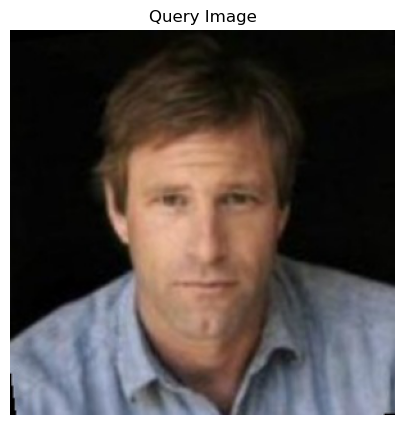

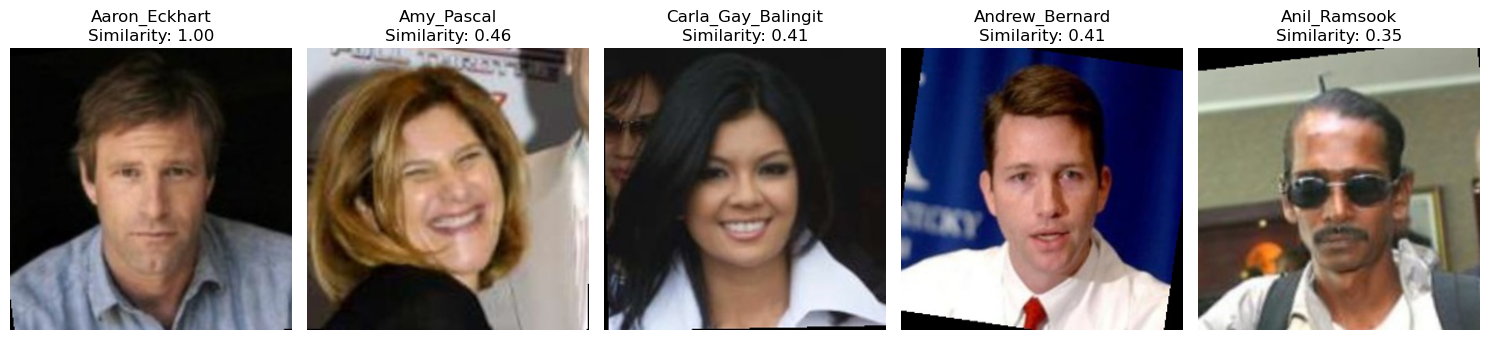

In [46]:
display_query_and_top_matches(query_image_path1)

### Example 2 (New query image)

In [49]:
# Stored Image
query_image_path2 = "test2.png"

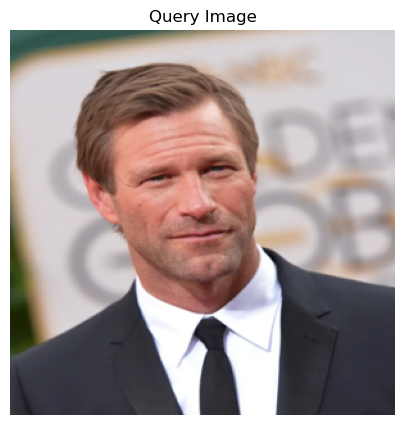

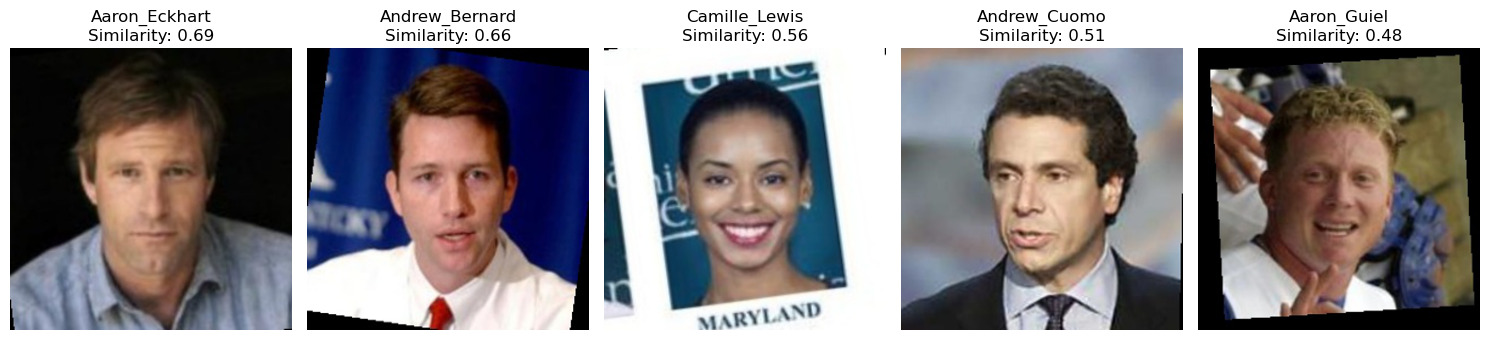

In [50]:
display_query_and_top_matches(query_image_path2)